# 📺 View channels

In [ ]:
#| default_exp repr_chans

In [ ]:
# |hide
from nbdev.showdoc import *
# from lovely_tensors import monkey_patch

In [ ]:
# |hide
# monkey_patch()

In [ ]:
# |hide
# |export
import numpy as np
from matplotlib.cm import get_cmap
# import torch
from lovely_numpy import lovely
from lovely_numpy.repr_rgb import RGBProxy, rgb
from lovely_numpy.utils.colormap import InfCmap

In [ ]:
# |exporti
def _chans(t: np.ndarray,         # Input tensor 
                 cmap = "coolwarm", # Use matplotlib colormap by this name
                 cm_below="blue", cm_above="red",
                 cm_ninf="cyan", cm_pinf="fuchsia",
                 cm_nan="yellow",
                 gutter_px=3,   # Draw write gutters when tiling the images
                 frame_px=1,    # Draw black frame around each image
                 view_width=966):    
    """
    Process individual channels of a tensor that can be interpreted as as image
    `x` and `y` specify which dimensions should be used as spatial ones.
    """
    
    assert t.ndim >= 2, f"Expected a 2 or 3-dim input, got {t.shape}={t.ndim}"
    if t.ndim == 2: t = t[None]
    
    ### XXX Do we want a way to pass a custom cmap instead of mpl one?
    tcmap = InfCmap(cmap=get_cmap(cmap),
                  below=cm_below, above=cm_above,
                  nan=cm_nan, ninf=cm_ninf, pinf=cm_pinf)

    return RGBProxy(tcmap(t))(cl=True, gutter_px=gutter_px, frame_px=frame_px, view_width=view_width)

In [ ]:
# |exporti
class ChanProxy():
    def __init__(self, t: np.ndarray):
        self.t = t
    
    def __call__(self,
                 cmap = "coolwarm", 
                 cm_below="blue",
                 cm_above="red",
                 cm_ninf="cyan",
                 cm_pinf="fuchsia",
                 cm_nan="yellow",
                 view_width=966,
                 gutter_px=3,
                 frame_px=1):
        
        return _chans(self.t,
                     cmap=cmap,
                     cm_below=cm_below,
                     cm_above=cm_above,
                     cm_ninf=cm_ninf,
                     cm_pinf=cm_pinf,
                     cm_nan=cm_nan,
                     view_width=view_width,
                     gutter_px=gutter_px,
                     frame_px=frame_px)
    
    def _repr_png_(self):
        return self.__call__()._repr_png_()

In [ ]:
# |export
def chans(t: np.ndarray,      # Input, shape=([...], H, W)
             cmap = "coolwarm", # Use matplotlib colormap by this name
             cm_below="blue",   # Color for values below 0
             cm_above="red",    # Color for values above 1
             cm_ninf="cyan",    # Color for -inf values
             cm_pinf="fuchsia", # Color for +inf values
             cm_nan="yellow",   # Color for NaN values
             view_width=966,    # Try to produce an image at most this wide
             gutter_px=3,       # Draw write gutters when tiling the images
             frame_px=1,        # Draw black frame around each image
             cl=False):     

    "Map tensor values to colors. RGB[A] color is added as channel-last"
    return ChanProxy(t)(cmap=cmap,
                         cm_below=cm_below,
                         cm_above=cm_above,
                         cm_ninf=cm_ninf,
                         cm_pinf=cm_pinf,
                         cm_nan=cm_nan,
                         view_width=view_width,
                         gutter_px=gutter_px,
                         frame_px=frame_px)

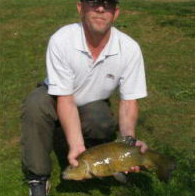

In [ ]:
in_stats = ( (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) )

image = np.load("mysteryman.npy")
image = (image * np.array(in_stats[1])[:,None,None])
image += np.array(in_stats[0])[:,None,None]

rgb(image, cl=0)

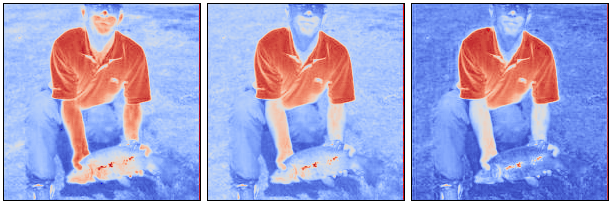

In [ ]:
chans(image)

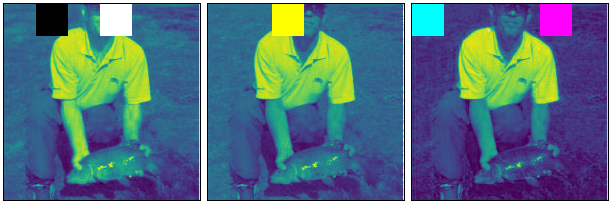

In [ ]:
# In R
image[0,0:32,32:64] = -0.1 # Below min
image[0,0:32,96:128] = 1.1 # Above max
# In G
image[1,0:32,64:96] = float("nan")
# In B
image[2,0:32,0:32] = float("-inf")
image[2,0:32,128:128+32] = float("+inf")

chans(image, cmap="viridis", cm_below="black", cm_above="white")

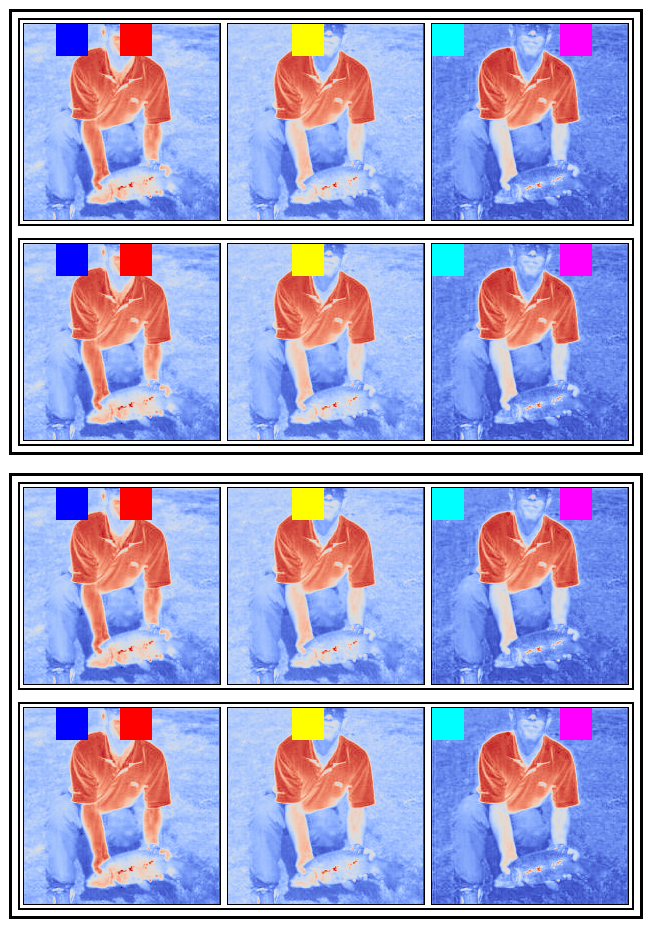

In [ ]:
# 4 images, stacked 2x2
chans(np.stack([image]*4).reshape((2,2,3,196,196)))

In [ ]:
# |hide
import nbdev; nbdev.nbdev_export()